<h3 style="text-align:center;">
Using Explainable AI to Unveil Gut Microbiome–Disease Relationships: A Comparative Approach
</h3>

In [15]:
#1. Import Libraries
import pandas as pd #Data Handling
import numpy as np #Data Handling
from sklearn.model_selection import train_test_split #Data Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier #Model Training
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix #Model Evaluation
import shap #Explainable AI
from lime import lime_tabular #Explainable AI

#2. Load Metadata
metadata = pd.read_csv("crc_baxter.metadata.txt", sep="\t")

# 1. For CRC dataset

In [28]:
#3. Load Microbiome OTU Table
otu = pd.read_csv("crc_baxter.otu_table.100.denovo.rdp_assigned", sep="\t", low_memory=False)
otu.head()
otu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122510 entries, 0 to 122509
Columns: 491 entries, Unnamed: 0 to 3323670
dtypes: int64(490), object(1)
memory usage: 458.9+ MB


In [30]:
#4. Transpose OTU table → Samples as rows
otu_t = otu.T
otu_t.reset_index(inplace=True)
otu_t.rename(columns={'index': 'Sample_Name_s'}, inplace=True)
(otu_t.head())

,Sample_Name_s,0,1,2,3,4,5,6,7,8,...,122500,122501,122502,122503,122504,122505,122506,122507,122508,122509
0,Unnamed: 0,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,...,k__Bacteria;p__Verrucomicrobia;c__Verrucomicro...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
1,2045653,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2087650,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2963670,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2527670,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
#5. Convert SampleName to string in both datasets
metadata['Sample_Name_s'] = metadata['Sample_Name_s'].astype(str).str.strip()
otu_t['Sample_Name_s'] = otu_t['Sample_Name_s'].astype(str).str.strip()

In [33]:
#6. Merge Metadata and Microbiome data
data = pd.merge(metadata, otu_t, on='Sample_Name_s', how='inner')
data.head()

,Sample_Name_s,Abx_s,Age_s,Asian_s,BMI_s,BioSample_s,Black_s,Diabetes_Med_s,Diabetic_s,Ethnic_s,...,122500,122501,122502,122503,122504,122505,122506,122507,122508,122509
0,2005650,0,61,0,28.0,SAMN03939372,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2003650,0,64,0,36.2,SAMN03939371,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2027653,0,65,0,21.5,SAMN03939381,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2025653,0,67,0,20.8,SAMN03939380,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023680,0,63,0,22.8,SAMN03939379,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#7. Remove ID column & handle zero variance
X = data.drop(columns=['DiseaseState', 'Sample_Name_s'], errors='ignore')
X = X.select_dtypes(include=[np.number])
X.columns = X.columns.astype(str)
y = data['DiseaseState']
print(X.head()) 
print(y[:10])   

   Abx_s  Age_s  Asian_s  Black_s  Diabetes_Med_s  Diabetic_s  Ethnic_s  \
0      0     61        0        0               0           0         0   
1      0     64        0        0               0           0         0   
2      0     65        0        0               0           0         1   
3      0     67        0        0               0           0         0   
4      0     63        0        0               0           0         0   

   Hx_Fam_CRC_s  Hx_Prev_s  Hx_of_Polyps_s  ...  Native_s  Other_s  Pacific_s  \
0             0          0               1  ...         0        0          0   
1             1          0               1  ...         0        0          0   
2             0          0               0  ...         0        0          0   
3             0          1               1  ...         0        0          0   
4             0          1               1  ...         0        0          0   

   Smoke_s  White_s  cancer_stage_s  fit_result_s  sample_titl

In [37]:
#8. Encode target
le = LabelEncoder()
y = le.fit_transform(y)

In [38]:
#9. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [23]:
#10. Impute missing values
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

#11. Train Model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

#12. Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6632653061224489

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86        24
           1       0.64      0.53      0.58        34
           2       0.58      0.62      0.60        40

    accuracy                           0.66        98
   macro avg       0.68      0.69      0.68        98
weighted avg       0.66      0.66      0.66        98


Confusion Matrix:
 [[22  0  2]
 [ 0 18 16]
 [ 5 10 25]]


#### Interpretation:
- Accuracy around 66% indicates the moderate predictive ability
- The confusion matrix indicates that healthy samples are predicted very well(22 out of 24 are correct)
- CRC samples are confused with the non CRC
- non CRC samples have moderate accuracy


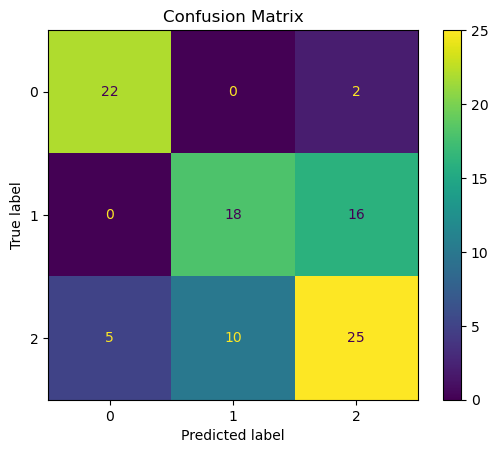

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

Fixed SHAP values shape: (98, 23, 3)
X_test shape: (98, 23)


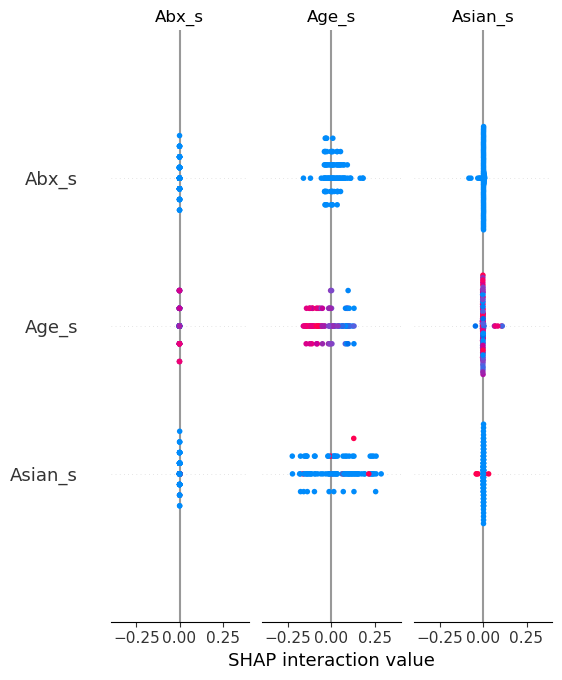

In [25]:
#Applying SHAP
explainer = shap.TreeExplainer(model)
raw_shap_values = explainer.shap_values(X_test)

#Step 1: Select correct SHAP values (binary/multiclass safe)
if isinstance(raw_shap_values, list):
    shap_values = raw_shap_values[1] if len(raw_shap_values) > 1 else raw_shap_values[0]
else:
    shap_values = raw_shap_values

#Step 2: Fix shape mismatch - remove extra columns (if any)
if shap_values.shape[1] != X_test.shape[1]:
    shap_values = shap_values[:, :X_test.shape[1]]

print("Fixed SHAP values shape:", shap_values.shape)
print("X_test shape:", X_test.shape)

#Step 3: Plot SHAP Summary
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

#### Interpretation:
- Age and Ethnicity are strong predictors here
- The use of antibiotics affects the overall composition of gut microbiome composition
- History Polyps & Family history also affect CRC risk

In [26]:
#14. LIME Local Explainability
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=X.columns.tolist(),
    mode="classification",
    discretize_continuous=False
)
#Selecting a patient and how the model predicted disease for that patient
i = 5  # Pick a test sample
exp = lime_explainer.explain_instance(
    X_test[i],
    model.predict_proba,
    num_features=10
)
exp.show_in_notebook()


#### Interpretation:
- Age_s= 75 indicates the strong positive for CRC
- Hx_of_Polys_s=1 indicates the presence of colon polyps significantly increases the CRC probability
- Diabetes_Med_s = 1 indicates diabetes and metabolic disorders promotes the inflammation
- Smoke_s indicates that smoking contributes to carcinogenic progression
- total_reads=4640, that microbiome diversity is also a factor
- Hx_Fam_CRC_s = 0 indicates no family history of CRC

# 2. Gut microbiome composition at the Genus level for Type 2 Diabetes (T2D) patients

In [42]:
import pandas as pd

# Load file (skip text header rows)
df = pd.read_excel("Table 3.xls", skiprows=2)

# Rename genus column
df.rename(columns={df.columns[0]: 'Genus'}, inplace=True)

df.head()


,Genus,T2D_A1,T2D_B1,T2D_C1,T2D_D1,T2D_E1,T2D_F1,T2D_G1,T2D_H1,T2D_I1,...,NGT_I2,NGT_J2,NGT_K2,NGT_L2,NGT_M2,NGT_N2,NGT_O2,NGT_P2,NGT_Q2,PValue
0,Prevotella_9,68.785599,74.462725,63.415040,88.511128,51.283401,47.397651,66.897203,70.668289,70.668289,...,68.891525,62.641343,28.402788,5.613604,48.525497,33.916640,28.458307,20.440920,5.756553,0.208445
1,Bacteroides,2.067116,2.392328,8.643878,0.672396,1.685252,0.227152,3.243522,1.678327,1.678327,...,0.878301,1.808883,4.297790,4.204067,3.661193,4.638880,19.000066,6.842189,15.721745,0.268255
2,Prevotella,1.319537,0.849997,4.385961,1.690552,2.151230,13.917746,2.653166,3.830131,3.830131,...,7.486243,1.649184,5.688863,18.821879,2.883319,2.707604,8.318853,5.157811,6.959021,0.130970
3,Alloprevotella,6.775679,6.602356,2.273649,0.465093,0.863068,1.084703,5.718208,3.864517,3.864517,...,0.217836,4.221896,1.907163,2.566620,5.030251,0.874960,2.043420,3.692308,9.965192,0.433882
4,Lachnospiraceae Incertae sedis,2.929799,1.018086,1.890368,0.081468,0.827784,5.272426,0.574910,2.134610,2.134610,...,0.631176,2.847316,6.133768,2.584151,4.020743,2.421254,2.500935,7.397304,4.184906,0.391590


In [43]:

# Converting all columns except 'Genus' to numeric
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Selecting only numeric columns
numeric_cols = df.columns[1:]   # all abundance columns

# Computing mean abundance per genus
df['Mean_Abundance'] = df[numeric_cols].mean(axis=1)

# Getting top 10 genera
top10 = df.sort_values(by='Mean_Abundance', ascending=False).head(10)
print(top10[['Genus', 'Mean_Abundance']])


                            Genus  Mean_Abundance
0                    Prevotella_9       45.362672
2                      Prevotella        5.121949
1                     Bacteroides        4.951702
3                  Alloprevotella        3.441386
4  Lachnospiraceae Incertae sedis        2.941348
5                Faecalibacterium        1.816472
6                   Succinivibrio        1.355981
7                       Roseburia        1.283621
8   Prevotellaceae Incertae sedis        1.033009
9                     Megasphaera        1.032141


#### Interpretation:
- Prevotella_9 domination suggests the microbial imbalance and inflammation and insulin resistance
- Beneficial genera like Faecalibacterium has low level indicating reduced gut functions, that is low anti-inflammatory

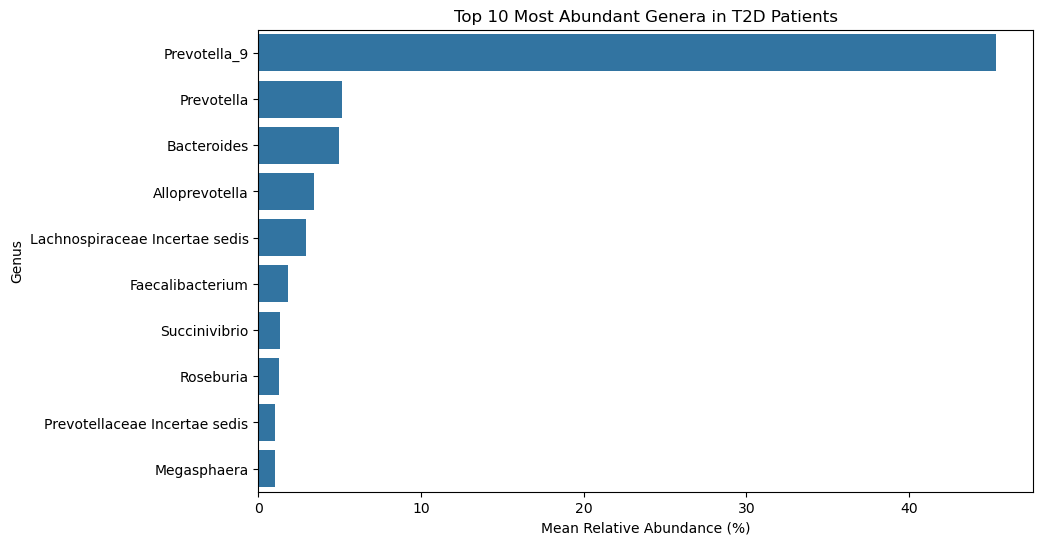

In [44]:
# Relative abundance barplot for top 10 genera
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=top10, x='Mean_Abundance', y='Genus')
plt.title("Top 10 Most Abundant Genera in T2D Patients")
plt.xlabel("Mean Relative Abundance (%)")
plt.ylabel("Genus")
plt.show()


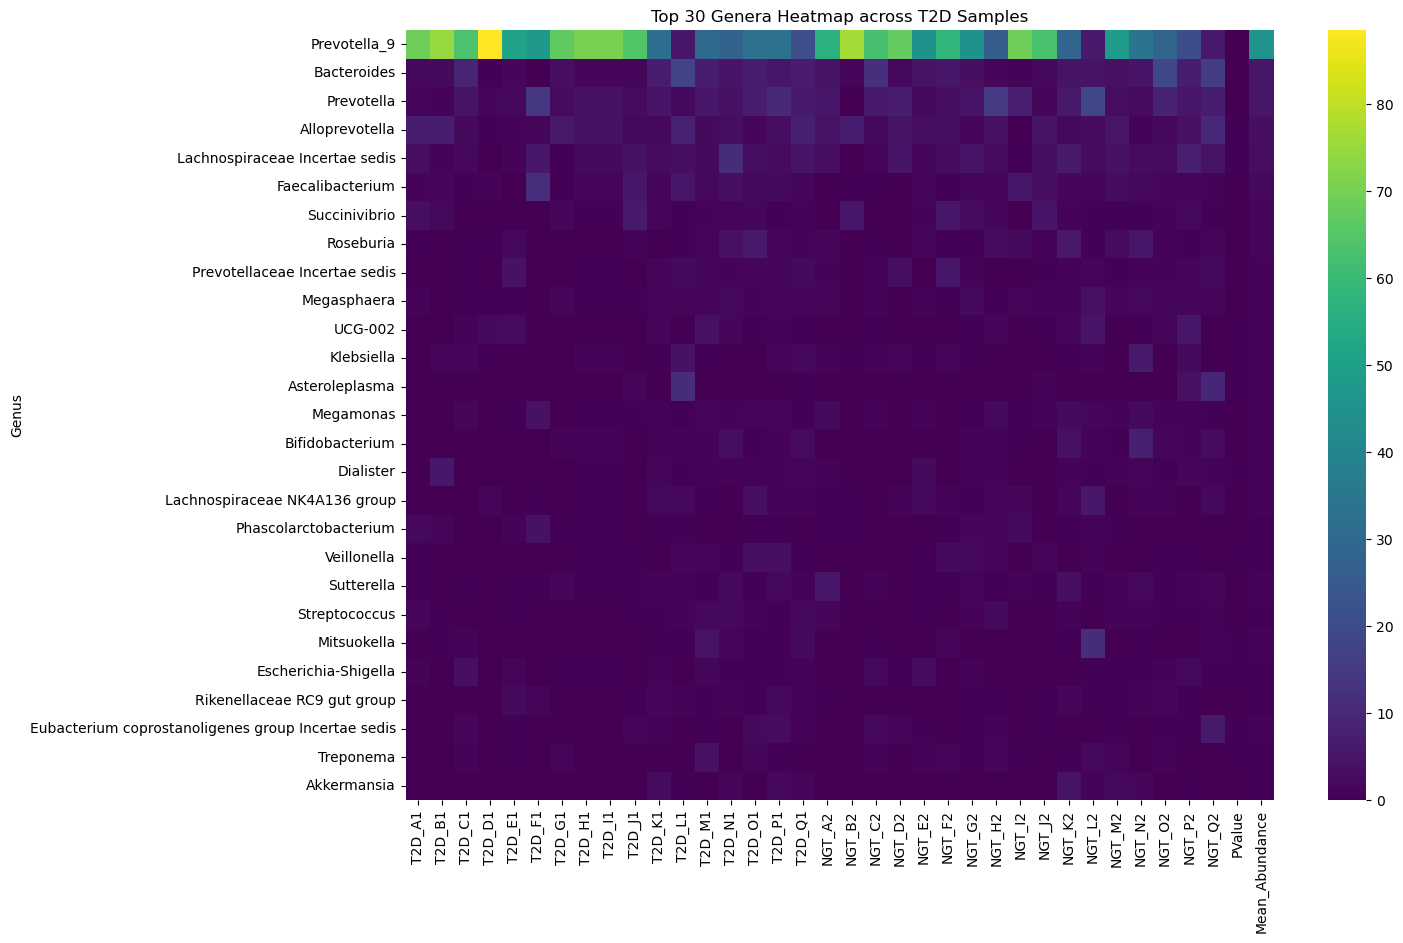

In [45]:
import seaborn as sns
plt.figure(figsize=(14,10))
sns.heatmap(df.set_index('Genus').iloc[:30], cmap='viridis')
plt.title("Top 30 Genera Heatmap across T2D Samples")
plt.show()


#### Interpretation:
- Rows are bacterial genera
- Columns are individual T2D samples
- The bright yellow represents high abundance of Prevotella_9 in multiple T2D patients
- Genera like Faecalibacterium, Roseburia, Bifidobacteriumhas dark purple, meaning it is rare, i.e these anti-inflammatory bacteria are rare in T2D patients and can lead to metabolic dysfunction
- Microbiome imbalance is visible here 

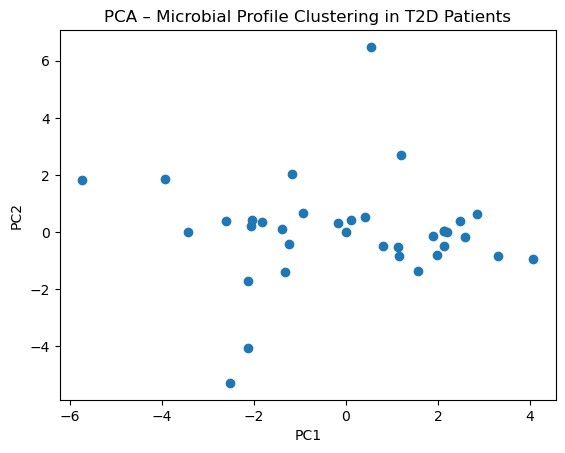

In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = df.set_index('Genus').T  # transpose for samples as rows
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

plt.scatter(pca_result[:,0], pca_result[:,1])
plt.title("PCA – Microbial Profile Clustering in T2D Patients")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


#### The results suggests that T2D is associated with multiple microbiome variations

<Axes: title={'center': 'Shannon Diversity'}, ylabel='Frequency'>

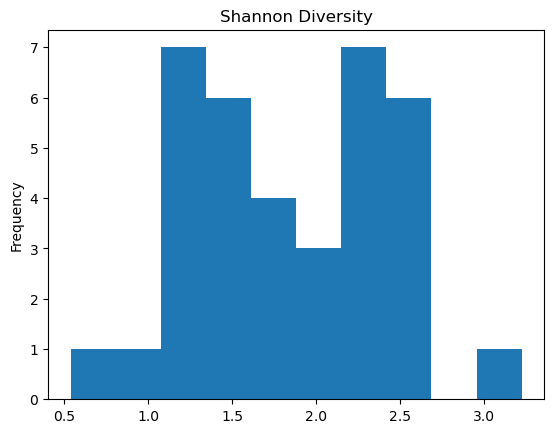

In [47]:
from scipy.stats import entropy

df.set_index('Genus', inplace=True)
df_T = df.T  # transpose

df_T['Shannon_Diversity'] = df_T.apply(lambda x: entropy(x), axis=1)
df_T['Shannon_Diversity'].plot(kind='hist', bins=10, title='Shannon Diversity')


#### Moderate to low diversity across T2D  can be seen here as well

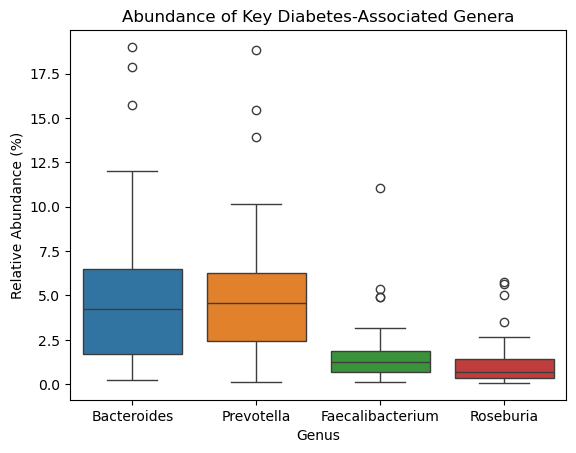

In [48]:
key_genera = ['Prevotella', 'Bacteroides', 'Roseburia', 'Faecalibacterium']
df_key = df[df.index.isin(key_genera)].T

sns.boxplot(data=df_key)
plt.title("Abundance of Key Diabetes-Associated Genera")
plt.ylabel("Relative Abundance (%)")
plt.show()


#### The results shows that Bacteroides, Prevotella, Faecalibacterium, Roseburia are the four clinically significant genera which leads to insulin resistance

In [49]:
import pandas as pd

df = pd.read_excel("Table 3.xls", skiprows=2)
df.rename(columns={df.columns[0]: 'Genus'}, inplace=True)

# Make genera as index
df = df.set_index('Genus')

# Convert all abundance columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')
df = df.fillna(0)

df.head()

,T2D_A1,T2D_B1,T2D_C1,T2D_D1,T2D_E1,T2D_F1,T2D_G1,T2D_H1,T2D_I1,T2D_J1,...,NGT_I2,NGT_J2,NGT_K2,NGT_L2,NGT_M2,NGT_N2,NGT_O2,NGT_P2,NGT_Q2,PValue
Genus,,,,,,,,,,,,,,,,,,,,,
Prevotella_9,68.785599,74.462725,63.415040,88.511128,51.283401,47.397651,66.897203,70.668289,70.668289,64.423533,...,68.891525,62.641343,28.402788,5.613604,48.525497,33.916640,28.458307,20.440920,5.756553,0.208445
Bacteroides,2.067116,2.392328,8.643878,0.672396,1.685252,0.227152,3.243522,1.678327,1.678327,1.066279,...,0.878301,1.808883,4.297790,4.204067,3.661193,4.638880,19.000066,6.842189,15.721745,0.268255
Prevotella,1.319537,0.849997,4.385961,1.690552,2.151230,13.917746,2.653166,3.830131,3.830131,2.547221,...,7.486243,1.649184,5.688863,18.821879,2.883319,2.707604,8.318853,5.157811,6.959021,0.130970
Alloprevotella,6.775679,6.602356,2.273649,0.465093,0.863068,1.084703,5.718208,3.864517,3.864517,2.053573,...,0.217836,4.221896,1.907163,2.566620,5.030251,0.874960,2.043420,3.692308,9.965192,0.433882
Lachnospiraceae Incertae sedis,2.929799,1.018086,1.890368,0.081468,0.827784,5.272426,0.574910,2.134610,2.134610,4.020829,...,0.631176,2.847316,6.133768,2.584151,4.020743,2.421254,2.500935,7.397304,4.184906,0.391590


In [18]:
X = df.T   # Samples become rows, genera become features
X.head()

Genus,Prevotella_9,Bacteroides,Prevotella,Alloprevotella,Lachnospiraceae Incertae sedis,Faecalibacterium,Succinivibrio,Roseburia,Prevotellaceae Incertae sedis,Megasphaera,...,Phascolarctobacterium,Veillonella,Sutterella,Streptococcus,Mitsuokella,Escherichia-Shigella,Rikenellaceae RC9 gut group,Eubacterium coprostanoligenes group Incertae sedis,Treponema,Akkermansia
T2D_A1,68.785599,2.067116,1.319537,6.775679,2.929799,0.911335,3.091181,0.409389,0.322764,0.822337,...,1.836909,0.665702,0.404642,1.493972,0.021359,0.784365,0.064078,0.100864,0.143583,0.036786
T2D_B1,74.462725,2.392328,0.849997,6.602356,1.018086,1.084539,1.898921,0.149846,0.032141,0.112928,...,1.360778,0.007818,0.046040,0.489063,0.456488,0.167654,0.025626,0.117705,0.036050,0.026060
T2D_C1,63.415040,8.643878,4.385961,2.273649,1.890368,0.577909,0.029450,0.568946,0.492546,0.505350,...,0.265053,0.007683,0.583884,0.114814,0.754184,3.366298,0.166885,1.546781,0.953507,0.023048
T2D_D1,88.511128,0.672396,1.690552,0.465093,0.081468,0.981821,0.008032,0.463563,0.013004,0.611200,...,0.032128,0.043602,0.035188,0.031746,0.035570,0.002677,0.199653,0.009562,0.000382,0.000382
T2D_E1,51.283401,1.685252,2.151230,0.863068,0.827784,0.200505,0.286196,1.763662,3.836482,0.665924,...,0.984604,0.096892,0.498463,0.425653,0.142258,1.276400,2.317011,0.416692,0.369646,0.133857


In [50]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choose number of clusters (try 2 or 3)
kmeans = KMeans(n_clusters=3, random_state=42) #K-Means clustering grouped T2D patients into three microbiome-based subtypes
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataset
X['Cluster'] = cluster_labels
X.head()


C:\Users\athir\anaconda3\ana\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Genus,Prevotella_9,Bacteroides,Prevotella,Alloprevotella,Lachnospiraceae Incertae sedis,Faecalibacterium,Succinivibrio,Roseburia,Prevotellaceae Incertae sedis,Megasphaera,...,Veillonella,Sutterella,Streptococcus,Mitsuokella,Escherichia-Shigella,Rikenellaceae RC9 gut group,Eubacterium coprostanoligenes group Incertae sedis,Treponema,Akkermansia,Cluster
T2D_A1,68.785599,2.067116,1.319537,6.775679,2.929799,0.911335,3.091181,0.409389,0.322764,0.822337,...,0.665702,0.404642,1.493972,0.021359,0.784365,0.064078,0.100864,0.143583,0.036786,1
T2D_B1,74.462725,2.392328,0.849997,6.602356,1.018086,1.084539,1.898921,0.149846,0.032141,0.112928,...,0.007818,0.046040,0.489063,0.456488,0.167654,0.025626,0.117705,0.036050,0.026060,1
T2D_C1,63.415040,8.643878,4.385961,2.273649,1.890368,0.577909,0.029450,0.568946,0.492546,0.505350,...,0.007683,0.583884,0.114814,0.754184,3.366298,0.166885,1.546781,0.953507,0.023048,2
T2D_D1,88.511128,0.672396,1.690552,0.465093,0.081468,0.981821,0.008032,0.463563,0.013004,0.611200,...,0.043602,0.035188,0.031746,0.035570,0.002677,0.199653,0.009562,0.000382,0.000382,1
T2D_E1,51.283401,1.685252,2.151230,0.863068,0.827784,0.200505,0.286196,1.763662,3.836482,0.665924,...,0.096892,0.498463,0.425653,0.142258,1.276400,2.317011,0.416692,0.369646,0.133857,2


In [21]:
# Convert to DataFrame
X['Cluster'] = cluster_labels

# Check cluster distribution
print(X['Cluster'].value_counts())

# Keep only clusters with at least 2 samples
X_filtered = X[X['Cluster'].map(X['Cluster'].value_counts()) >= 2]

# Separate features and target again
y = X_filtered['Cluster']
X_features = X_filtered.drop(columns=['Cluster'])

print("New shape:", X_filtered.shape)
print("New cluster counts:")
print(y.value_counts())
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y,
    test_size=0.2,
    random_state=42,
    stratify=y        # Now safe to stratify
)


Cluster
1    19
0    15
2     1
Name: count, dtype: int64
New shape: (34, 28)
New cluster counts:
Cluster
1    19
0    15
Name: count, dtype: int64


#### Interpretation:
- The dataset is labeled to represent the microbiome-based subtyoes of T2D patients.
- Data is then split into testing and training datasets

SHAP shape: (7, 27, 2)
X_test shape: (7, 27)


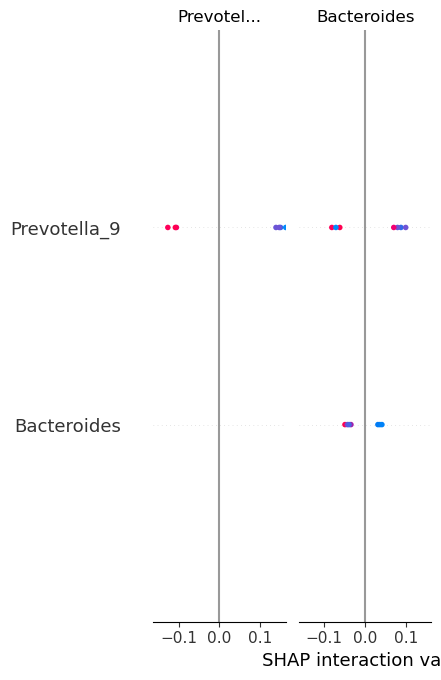

In [23]:
import shap

# Convert SHAP values to numpy array if list
if isinstance(shap_values, list):
    shap_values = shap_values[0]  # Use first class for clustering

# Fix shape mismatch (trim extra columns)
if shap_values.shape[1] != X_test.shape[1]:
    shap_values = shap_values[:, :X_test.shape[1]]

print("SHAP shape:", shap_values.shape)
print("X_test shape:", X_test.shape)

# Now plot safely
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


#### High abundance of Prevotella_9 and Bacteroides majorly drives the prediction of certain microbiome-based T2D clusters, which indicates their important role in defining the gut dysbiosis patterns

len(crc_feature_names): 28
len(mean_abs_shap): 69

Top CRC-important genera (by SHAP):
                                                Genus  MeanAbsSHAP
4                      Lachnospiraceae Incertae sedis     0.077023
24  Eubacterium coprostanoligenes group Incertae s...     0.059826
5                                    Faecalibacterium     0.058397
26                                        Akkermansia     0.058154
27                                            Cluster     0.031256
3                                      Alloprevotella     0.019769
25                                          Treponema     0.009200
14                                    Bifidobacterium     0.005673
13                                          Megamonas     0.005545
16                      Lachnospiraceae NK4A136 group     0.005103
22                               Escherichia-Shigella     0.005064
23                        Rikenellaceae RC9 gut group     0.004940
17                              Phascolarc

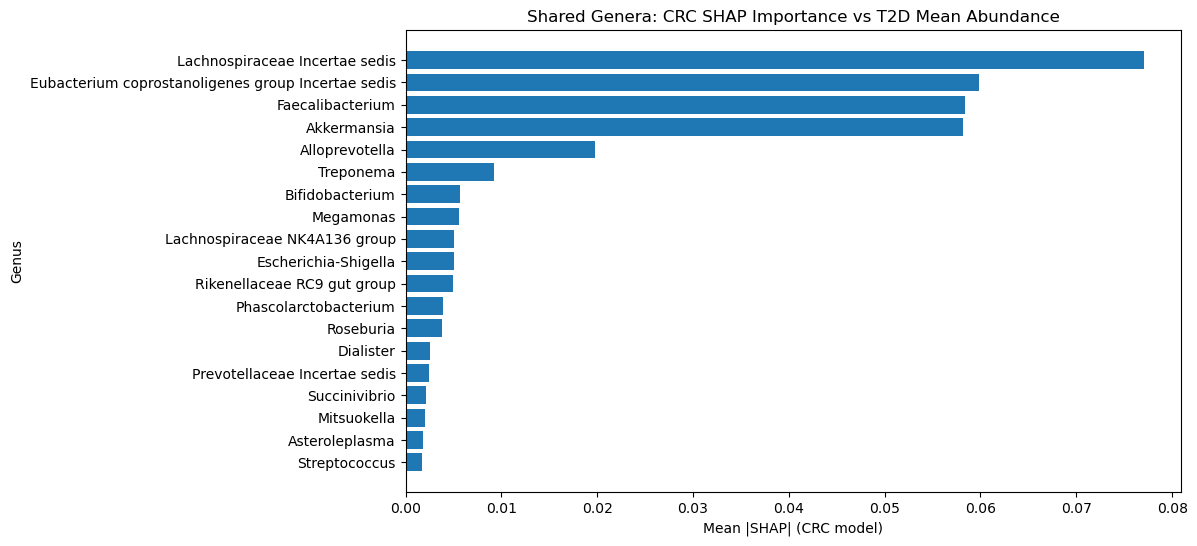

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Existing SHAP values from CRC model
shap_values_crc = shap_values   # make sure shap_values is already computed

# -------------------------------------------
# 1. CRC: Global SHAP importance per feature
# -------------------------------------------

mean_abs_shap = np.mean(np.abs(shap_values_crc), axis=0)

mean_abs_shap = np.array(mean_abs_shap).reshape(-1)
crc_feature_names = np.array(X.columns).astype(str).reshape(-1)

print("len(crc_feature_names):", len(crc_feature_names))
print("len(mean_abs_shap):", len(mean_abs_shap))

n = min(len(crc_feature_names), len(mean_abs_shap))

crc_importance = pd.DataFrame(
    list(zip(crc_feature_names[:n], mean_abs_shap[:n])),
    columns=['Genus', 'MeanAbsSHAP']
)

topN = 20
crc_top = crc_importance.sort_values('MeanAbsSHAP', ascending=False).head(topN)
print("\nTop CRC-important genera (by SHAP):")
print(crc_top)

# -------------------------------------------
# 2. T2D: Build Genus + Mean_Abundance from df
# -------------------------------------------
# df should be T2D table, with
#    'Genus' as column, or
#   - 'Genus' as index

t2d_df = df.copy()

# If Genus is NOT a column, assume it's the index
if 'Genus' not in t2d_df.columns:
    t2d_df = t2d_df.copy()
    t2d_df['Genus'] = t2d_df.index.astype(str)

# All columns except 'Genus' are assumed abundance columns
abundance_cols = [c for c in t2d_df.columns if c != 'Genus']

# Make sure they are numeric
t2d_df[abundance_cols] = t2d_df[abundance_cols].apply(
    pd.to_numeric, errors='coerce'
)

# Compute mean abundance across samples
t2d_df['Mean_Abundance'] = t2d_df[abundance_cols].mean(axis=1)

t2d_genera = t2d_df[['Genus', 'Mean_Abundance']]

# -------------------------------------------
# 3. INTERSECTION: genera present in both
# -------------------------------------------
# Make sure 'Genus' is only a column, not also an index name
crc_top = crc_top.reset_index(drop=True)
crc_top.index.name = None

t2d_genera = t2d_genera.reset_index(drop=True)
t2d_genera.index.name = None

comparison = pd.merge(crc_top, t2d_genera, on='Genus', how='inner')

print("\nCommon genera between CRC-important (SHAP) and T2D Table 3:")
print(comparison.sort_values('MeanAbsSHAP', ascending=False))





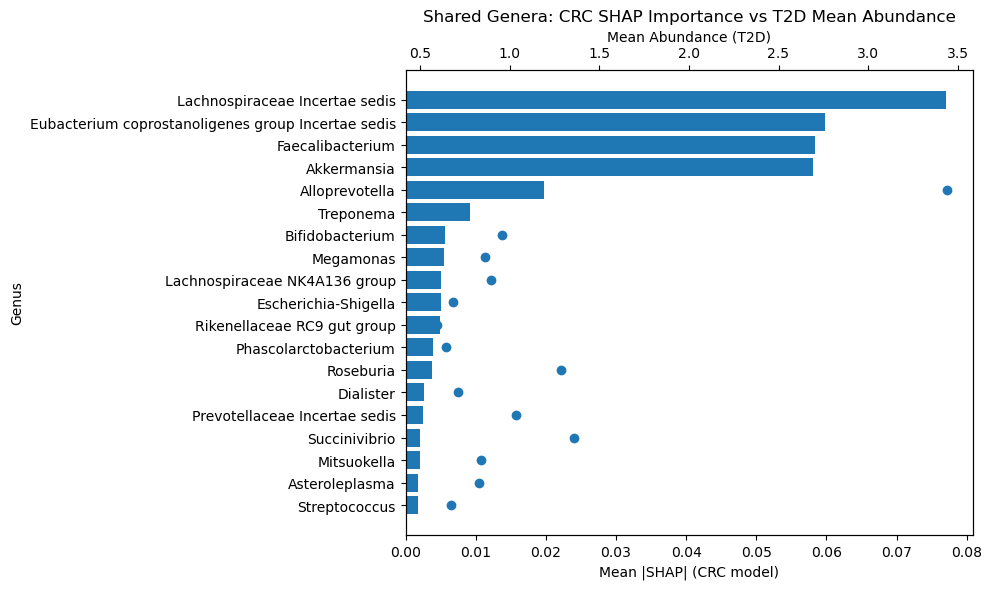

In [55]:
# -------------------------------------------
# 4. Visualization 
# -------------------------------------------
if not comparison.empty:
    comparison_sorted = comparison.sort_values('MeanAbsSHAP', ascending=False)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar: CRC importance
    ax1.barh(comparison_sorted['Genus'], comparison_sorted['MeanAbsSHAP'])
    ax1.invert_yaxis()
    ax1.set_xlabel("Mean |SHAP| (CRC model)")
    ax1.set_ylabel("Genus")
    ax1.set_title("Shared Genera: CRC SHAP Importance vs T2D Mean Abundance")

# Points: T2D abundance on secondary x-axis
    ax2 = ax1.twiny()
    ax2.plot(comparison_sorted['Mean_Abundance'], comparison_sorted['Genus'], 'o')
    ax2.set_xlabel("Mean Abundance (T2D)")

    plt.tight_layout()
    plt.show()
else:
    print("\n No overlapping genera found between CRC SHAP features and T2D Table 3.")

##### Based on SHAP-based feature importance from the CRC and the mean genus abundance from the T2D cohort, the overlapping genera that are both predictive of CRC and T2D was identified, which suggests the possible overlap of the microbial signatures linking the metabolic dysregulation and colorectal carcinogenesis. Here, Faecalibacterium, Akkermansia, Alloprevotella, Roseburia were seen as the common microbiome in both diseases and are the most shared genera between the CRC SHAP importance and T2D abundance,which indicates the  strong involvement in both metabolic dysbiosis and cancer risk.